In [1]:
import glob
import os
from lsst import afw
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_E2V, plotonesensor_E2V_smooth, create_combined_E2V, plotfullraft, plotonesensor_E2V_andsave, internaladjustment
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+5


In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-024/RTM-024-11351-S00_superbias_normal.fits" # bottom left
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-024/RTM-024-11351-S00_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-024/11351/qe_raft_acq/v0/88290/S00/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)


wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma

# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))

weights = numpy.interp(wls, x, y)   


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


In [3]:

# function to load and parce through QE data to make a list of combined images, each element of the list is an image for one amplifier/segment in the E2V sensor
def create_combined_E2V(superdarkpath, superbiaspath, qeflatpath, weights, title):    
    superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
    superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias
    num_ch = 16
    img_list = []
    MEDIAN = None

    # loops over each amplifier in the CCD
    for ch in range(num_ch):
        arr = []                # defines an empty array for storing new combined flat for each amplifier
        for i, aqeflatpath in enumerate(qeflatpath):
            aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)

            img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array

            MEDIAN = numpy.median(img)
            img = img/MEDIAN     # this will normalize your image

            arr.append(img*weights[i])

        img = numpy.sum(arr,axis=0)/numpy.sum(weights)   # NEED THIS LINE TO MAKE COMBINED IN UV BAND (weights function called)
        std = mad_std(img)
        # puts images into a list to use below
        img_list.append(img)  
        
    #plotonesensor_E2V(img_list, title)
    return img_list

In [4]:

raft = 'R22'
title = 'COMBINED ' + str(raft) + '_S00'
img_list = create_combined_E2V(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
print(len(img_list))
                                                                                                                             
def create_ccob(img_list):
    num_ch = 16
    red_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R22_S11_red_-10.005_10.245.fits"     ##  center pointing
    ccob_red = get_ccd_from_id(None, fname, [])

    for ch in range(num_ch):    
        red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBr flat field image
        MEDIAN = numpy.median(red)                                        # median (not mean, avoiding outliers) of QE data array for CCOBred, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        red_arr[ch] = red        
    
    return normedimg_arr, red_arr

create_ccob(img_list)
normedimg_arr, red_arr = create_ccob(img_list)

16


In [19]:
def plotonesensor_E2V(img_list, title, relativenorm=None):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    num_ch = 16
    
    img_list_copy = img_list.copy()
    print(len(img_list))
    img_list_slice = img_list_copy[0:4] + img_list_copy[4:15]
    
    image_com = None
    wholepixels = numpy.array(img_list_slice).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = mad_std(wholepixels)
    ax = []
    image_com = []  # empty list to store data for COMBINED image
    
    print(len(img_list))
    print(len(img_list_slice))
    for i in range(num_ch):
        if i < columns:
            image_com.append(numpy.rot90(img_list[i + 8], 2))
        else:
            image_com.append(img_list[num_ch - (i + 1)])
    
    if relativenorm is None:
        relativenorm = internaladjustment(image_com)
    N = 0.5
    print(relativenorm)
    
    for i in range(0,16):
        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])
        im = plt.imshow(image_com[i]*relativenorm[i], vmin=mean-N*std,vmax=mean+N*std,origin="lower")
        
    plt.suptitle(title)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return image_com
    

16
16
16
15
[1.         0.9989863  0.99847101 0.99980804 0.99887862 0.99948377
 1.00049652 1.00196138 1.00304711 1.00220664 1.00378511 1.0008265
 1.0024127  1.00267535 1.00165381 1.00328191]
[1.         0.9989863  0.99847101 0.99980804 0.99887862 0.99948377
 1.00049652 1.00196138 1.00435368 1.00351211 1.00509264 1.00213018
 1.00371844 1.00398144 1.00295856 1.00458879]


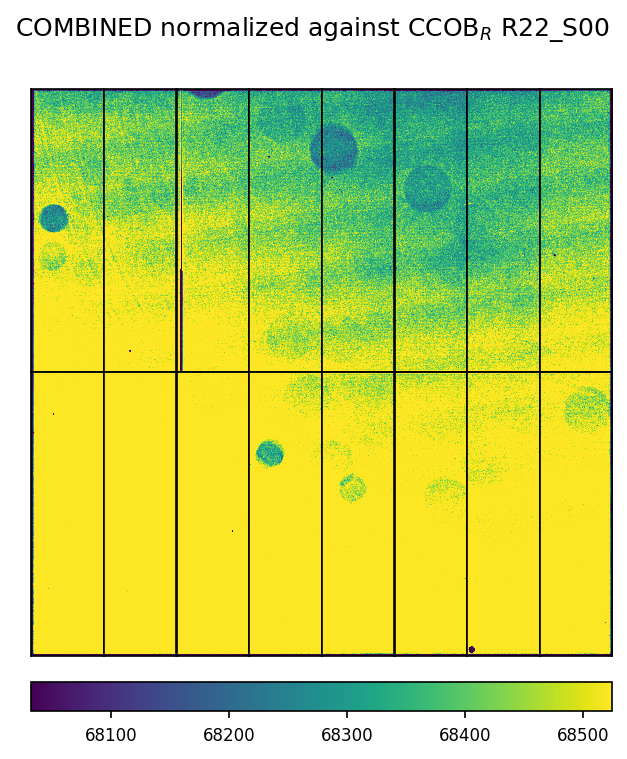

[1.         0.9989863  0.99847101 0.99980804 0.99887862 0.99948377
 1.00049652 1.00196138 1.00304711 1.00220664 1.00378511 1.0008265
 1.0024127  1.00267535 1.00165381 1.00328191]
16
16
15
[1.         0.99908477 0.99881584 1.0009705  1.00069414 1.0013073
 1.00170204 1.00228704 0.99619144 0.99587181 0.99783836 0.99570353
 0.99768684 0.99813926 0.9970732  0.99841382]
[1.         0.99908477 0.99881584 1.0009705  1.00069414 1.0013073
 1.00170204 1.00228704 0.99948523 0.99916454 1.0011376  0.99899571
 1.00098558 1.0014395  1.00036991 1.00171497]


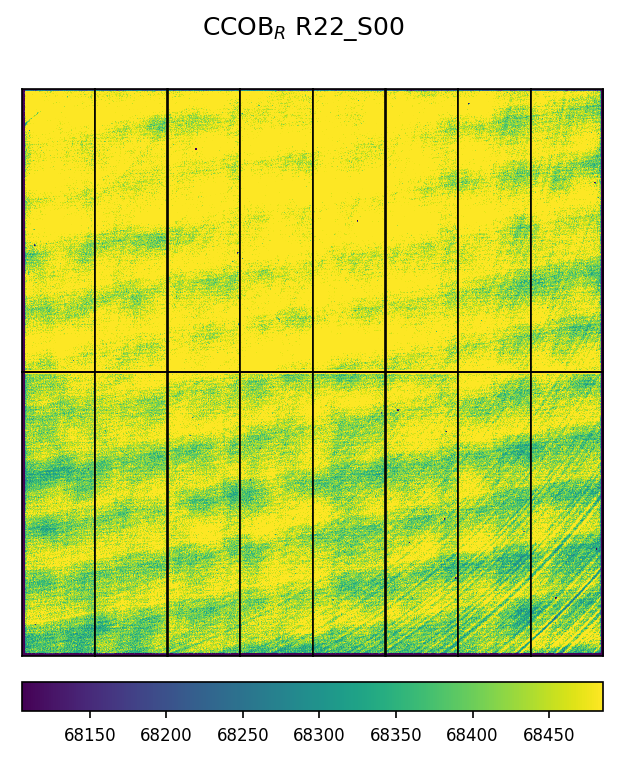

[1.         0.99908477 0.99881584 1.0009705  1.00069414 1.0013073
 1.00170204 1.00228704 0.99619144 0.99587181 0.99783836 0.99570353
 0.99768684 0.99813926 0.9970732  0.99841382]
16
16


In [20]:
num_ch = 16
raft = 'R22'
filter_band = 'R'

print(len(img_list))
image_com = plotonesensor_E2V(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ ' + str(raft) + '_S00')
com_relnorm = internaladjustment(image_com)

image_com = plotonesensor_E2V(red_arr, 'CCOB$_{R}$ ' + str(raft) + '_S00')
ccob_relnorm = internaladjustment(image_com)

relnorm = com_relnorm/ccob_relnorm

print(len(normedimg_arr))
print(len(red_arr))


In [27]:
def plotonesensor_E2V(img_list, title, relativenorm=None):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    num_ch = 16
    
    img_list_copy = img_list.copy()
    print(len(img_list))
    img_list_slice = img_list_copy[0:4] + img_list_copy[4:15]
    
    image_com = None
    wholepixels = numpy.array(img_list_slice).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = mad_std(wholepixels)
    ax = []
    image_com = []  # empty list to store data for COMBINED image
    
    print(len(img_list))
    print(len(img_list_slice))
    for i in range(num_ch):
        if i < columns:
            image_com.append(numpy.rot90(img_list[i + 8], 2))
        else:
            image_com.append(img_list[num_ch - (i + 1)])
    
    if relativenorm is None:
        relativenorm = internaladjustment(image_com)
    N = 0.5
    print(relativenorm)
    
    for i in range(0,16):
        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])
        im = plt.imshow(image_com[i]*relativenorm[i], vmin=mean-N*std,vmax=mean+N*std,origin="lower")
        
    plt.suptitle(title)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return image_com


# plotting one E2V sensor and saving the figure as an image for displaying full raft
def plotonesensor_E2V_andsave_badchannel(diff_arr, relativenorm=None):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    
    diff_arr_copy = diff_arr.copy()
    diff_arr_slice = diff_arr_copy[0:4] + diff_arr_copy[4:15]
   
    image_com = None
    wholepixels = numpy.array(diff_arr_slice).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = mad_std(wholepixels)
    ax = []
    image_com = []
    
    for j in range(num_ch):
        if j < columns:
            image_com.append(numpy.rot90(diff_arr[j + 8], 2))
        else:
            image_com.append(diff_arr[num_ch - (j + 1)])

    if relativenorm is None:
        relativenorm = internaladjustment(image_com)
    N = 0.5
    
    for k in range(0,16):
        ax1 = fig.add_subplot(rows, columns, k + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])
        im = plt.imshow(image_com[k]*relativenorm[k], vmin=mean-N*std,vmax=mean+N*std,origin="lower")
        
    plt.suptitle('Differential Ratio between COMBINED and CCOB S00')
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig("badchannel_R22_S00.png")
    return image_com

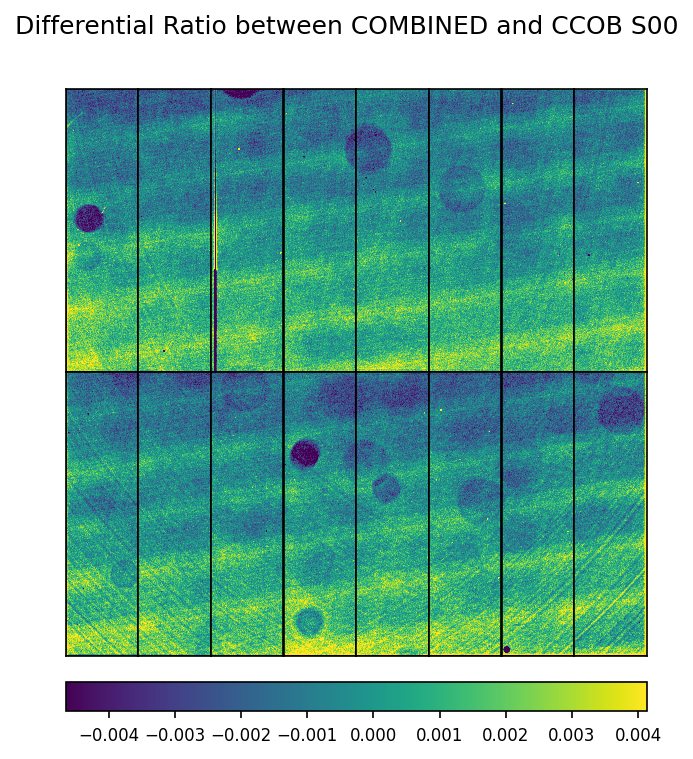

In [28]:
diff_arr = [None] * num_ch
for ch in range(num_ch):
    diff_arr[ch] = (normedimg_arr[ch] - red_arr[ch]) / red_arr[ch]
plotonesensor_E2V_andsave_badchannel(diff_arr, relativenorm=relnorm)
print()